In [5]:
import random  # for demo script
import os
import argparse
import math
import urllib.request
import io

import IPython
from PIL import Image
import cv2
import matplotlib
import rioxarray

import numpy as np

import geopandas as gpd
from pyproj import Proj, transform

import ultralytics
from ultralytics import YOLO
from ultralytics import settings
#ultralytics.checks()
#import wandb
import matplotlib.pyplot as plt

import rasterio as rio
import xarray as xr
import wandb

In [2]:
os.chdir("/work/csr33/object_detection")
# Update settings
# https://docs.ultralytics.com/quickstart/
os.makedirs('/work/csr33/object_detection/weights', exist_ok=True)
settings.update({'weights_dir': '/work/csr33/object_detection/weights'})

os.makedirs('/work/csr33/object_detection/runs', exist_ok=True)
settings.update({'runs_dir': '/work/csr33/object_detection/runs'})

settings.update({'neptune': False, 'clearml': False, 
                 "raytune": False, #'comet': True, 'raytune': True,
                 'dvc': False, 'hub': False, 'mlflow': False,
                 'tensorboard': False, 'wandb': True})

In [6]:
#Set up wandb
WANDB_API_KEY="006286beb62f8eedc5994d45a84434bf72b09040"
# Name and notes optional
WANDB_NAME="My first run"
WANDB_NOTES="Smaller learning rate, more regularization."
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: csr33 (turn). Use `wandb login --relogin` to force relogin


True

In [7]:
def get_args_parse():
    parser = argparse.ArgumentParser("Exploratory Data Analysis")
    parser.add_argument("--data", default="/hpc/home/csr33/ast_object_detection/ast.yaml", type=str)
    parser.add_argument("--model", default='yolov8n.pt', type=str)
    parser.add_argument("--batch", default=8, type=int)
    parser.add_argument("--imgsz", default=640, type=int)
    parser.add_argument("--epochs", default=2, type=int)
    args = parser.parse_args()
    return args

In [8]:
import sys
sys.argv = ['my_notebook']
args = get_args_parse()

In [9]:
model_path="/work/csr33/object_detection/runs/detect/baseline_train/weights/best.pt"
item_dim = 640
best_hyper_parameter_yaml = "/work/csr33/object_detection/runs/detect/tune3/best_hyperparameters.yaml"

In [10]:
naip_df = gpd.read_parquet("/work/csr33/images_for_predictions/naip_tile_in_slosh_modeled_area.parquet")

In [7]:
IPython.display.Image(url=naip_df.assets.iloc[0]["image"]["href"])

In [11]:
subset = naip_df.cx[-95.272028:-95.250742, 29.694444:29.736785]

In [98]:
#IPython.display.Image(url = subset.assets.iloc[0]["rendered_preview"]["href"], width=500)

In [14]:
tile.band
#RGBI, red (wavelength) band as band 1, green as band 2, blue as band 3, and near infrared as band 4

#height - width- channel -HWC format with BGR channels uint8 (0-255).

In [30]:
def data_processing(url, item_dim=640):
    #read in image
    tile = rioxarray.open_rasterio(url)#.squeeze()
    crs = tile[0].rio.crs
    tile_channels, tile_height, tile_width = tile.shape  # the size of the tile
    # divide the tile into item_dim by item_dim chips (rounding up)
    row_index = math.ceil(tile_height / item_dim)
    col_index = math.ceil(tile_width / item_dim)   
    # determine slices for tile
    row_col_pairs = [[y,x] for y in range(row_index) for x in range(col_index)]
    slice_indices = [[[x*item_dim, x*item_dim+item_dim], [y*item_dim, y*item_dim+item_dim]] for y in range(row_index) for x in range(col_index)]
    #split tile data array
    split_tile = [tile.isel(x=slice(s[0][0], s[0][1]), y=slice(s[1][0], s[1][1])) for s in slice_indices]
    
    # extract values and format
    split_tile_values = [s.values for s in split_tile]
    split_tile_values = [np.transpose(s, (1, 2, 0)) for s in split_tile_values] #reogrganize CHW to to HWC
    split_tile_values = [s[:, :, [2, 1, 0]] for s in split_tile_values]  # The image is red in as RGB, Swap to BGRR and B channels,  Assuming the array is in RGB format, reverse the channels to get BGR
    split_tile_values = [np.ascontiguousarray(s) for s in split_tile_values]  # ensure the tile is contiguous 
    return row_col_pairs, split_tile, split_tile_values, crs


def utm_to_latlon(utmx, utmy, crs):
    utm_proj = Proj(crs)  # UTM zone 15, northern hemisphere
    lon, lat = utm_proj(utmx, utmy, inverse=True) #x, y
    return lon, lat 


In [13]:
tile = rioxarray.open_rasterio(subset.assets.iloc[0]["image"]["href"])#.squeeze()
x_coords = tile.coords['x'].values
y_coords = tile.coords['y'].values

In [28]:
index_closest = np.abs(x_coords - 282135.20).argmin()
x_coords[index_closest]

282135.3

In [55]:

index_closest = np.abs(split_tile[159].x - 282135.20).argmin()
split_tile[159].x[index_closest].values
index_closest

<xarray.DataArray 'x' ()>
array(565)
Coordinates:
    spatial_ref  int64 0

In [56]:
xyxy

array([467, 532, 492, 556], dtype=int32)

In [ ]:
282135.20 easting
3290230.66 northing


In [114]:
def convert_bbox_coords_utm_lat_lon(split_tile, xyxy, crs):
    #bbox coordinates
    minx, miny, maxx, maxy = xyxy
    print(minx, miny, maxx, maxy)
    x_coords = split_tile.coords['x'].values
    y_coords = split_tile.coords['y'].values
    lon_lat_minx, lon_lat_miny = utm_to_latlon(x_coords[minx], y_coords[miny], crs)
    lon_lat_maxx, lon_lat_maxy = utm_to_latlon(x_coords[maxx], y_coords[maxy], crs)
    return [[lon_lat_minx, lon_lat_miny],[lon_lat_maxx, lon_lat_maxy]]

In [117]:
#process the url 
row_col_pairs, split_tiles, split_tile_values, crs = data_processing(url=subset.assets.iloc[0]["image"]["href"], item_dim=640)

# run prediction


#obtain coordinates
for split_tile, split_tile_value in zip(split_tiles, split_tile_values):
    convert_bbox_coords_utm_lat_lon(split_tile, xyxy[0], crs)

In [90]:

print(x_coords[467], x_coords[492])
print(y_coords[532], y_coords[556])

282076.5 282091.5
3290134.5 3290120.1


In [76]:
xyxy[0]
282081.26 3290129.80

array([467, 532, 492, 556], dtype=int32)

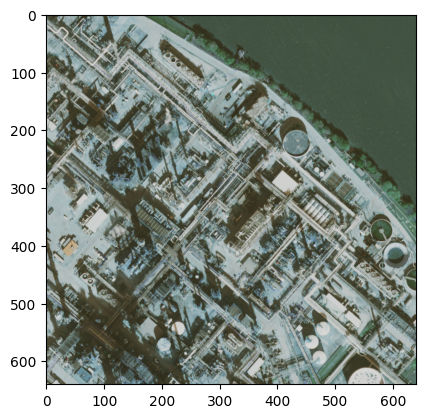

In [77]:
IPython.display.Image("/work/csr33/object_detection/runs/detect/predict27/image0.jpg")
plt.imshow(split_tile_values[159]) #rows (y), columns (x)
#plt.imshow(split_tile_values[159][xyxy[0][1]:xyxy[0][3], xyxy[0][0]:xyxy[0][2]]) #rows (y), columns (x)

In [66]:
model = YOLO(model_path)  # custom trained model 
# Run inference on 'bus.jpg' with arguments
results = model.predict(split_tile_values[159], save=True, imgsz=640, conf=0.5)

xyxy_list = []
# Process results generator
for result in results:
    xyxy = result.boxes.xyxy.cpu().detach().numpy()
    xyxy = np.round(xyxy).astype(np.int32) # Boxes object for bbox outputs
    probs = result.probs  # Probs object for classification outputs
    
plt.imshow(split_tile_values[159][xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]) #rows (y), columns (x)


0: 640x640 2 sedimentation_tanks, 6 closed_roof_tanks, 2 external_floating_roof_tanks, 29.5ms
Speed: 2.1ms preprocess, 29.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /work/csr33/object_detection/runs/detect/predict32


TypeError: only integer scalar arrays can be converted to a scalar index

array([467, 532, 492, 556], dtype=int32)

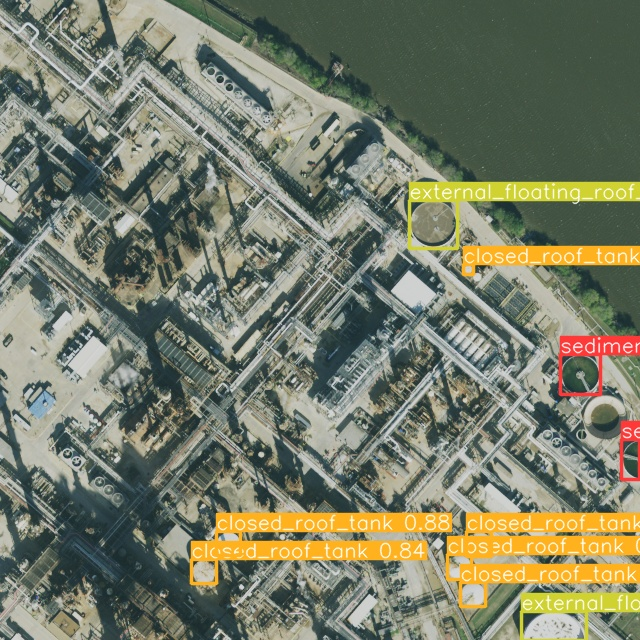

In [44]:
xyxy
Easting 282062.28
Northing 3290124.63

array([467, 532, 492, 556], dtype=int32)

In [43]:
convert_bbox_coords_utm_lat_lon(split_tile[159], xyxy, crs)

276316.5 3293206.5
-95.3130985477816 29.748930002180415
-95.31294055656413 29.748802860142995


In [121]:
split_tile[160].x

<xarray.DataArray 'x' (x: 640)>
array([282180.3, 282180.9, 282181.5, ..., 282562.5, 282563.1, 282563.7])
Coordinates:
  * x            (x) float64 2.822e+05 2.822e+05 ... 2.826e+05 2.826e+05
    spatial_ref  int64 0

In [125]:
tile.x

<xarray.DataArray 'x' (x: 10980)>
array([276036.3, 276036.9, 276037.5, ..., 282622.5, 282623.1, 282623.7])
Coordinates:
  * x            (x) float64 2.76e+05 2.76e+05 2.76e+05 ... 2.826e+05 2.826e+05
    spatial_ref  int64 0

In [130]:
split_tile[140].y

<xarray.DataArray 'y' (y: 640)>
array([3290837.7, 3290837.1, 3290836.5, ..., 3290455.5, 3290454.9, 3290454.3])
Coordinates:
  * y            (y) float64 3.291e+06 3.291e+06 3.291e+06 ... 3.29e+06 3.29e+06
    spatial_ref  int64 0

In [122]:
split_tile[160].y

<xarray.DataArray 'y' (y: 640)>
array([3290453.7, 3290453.1, 3290452.5, ..., 3290071.5, 3290070.9, 3290070.3])
Coordinates:
  * y            (y) float64 3.29e+06 3.29e+06 3.29e+06 ... 3.29e+06 3.29e+06
    spatial_ref  int64 0

In [118]:
xyxy

array([ 89, 610, 116, 636], dtype=int32)

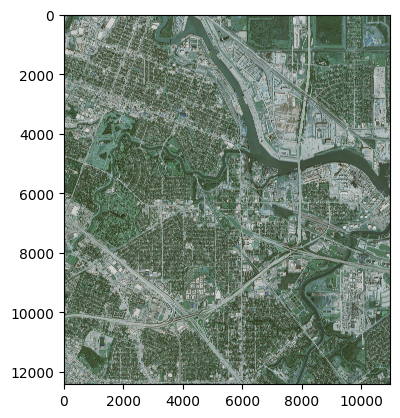

In [111]:
plt.imshow(np.ascontiguousarray(np.transpose(tile.values, (1, 2, 0))[:, :, [2, 1, 0]] ) )

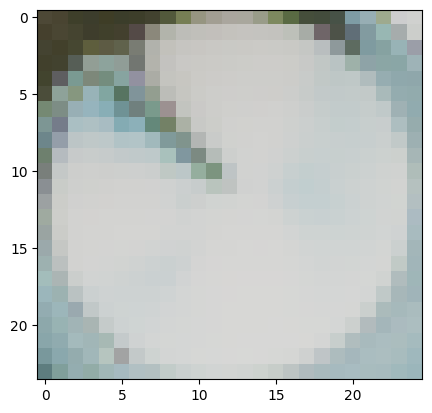

In [42]:
plt.imshow(split_tile_values[159][xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]) #rows (y), columns (x)

In [67]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
print(arr[0:1])#, 1:4])

[[1 2 3 4 5]]


In [30]:
xyxy[0]#:xyxy[2]

89.26401

In [25]:
np.round().astype(int)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
t = tf.constant([1.2, 2.7, 3.14, 4.8])

t_np = t.numpy()
t_rounded_np = 

t_rounded = tf.convert_to_tensor(t_rounded_np)

In [13]:
split_tile_values[160]

In [ ]:
subset = arr
subset

In [160]:
plt.show()

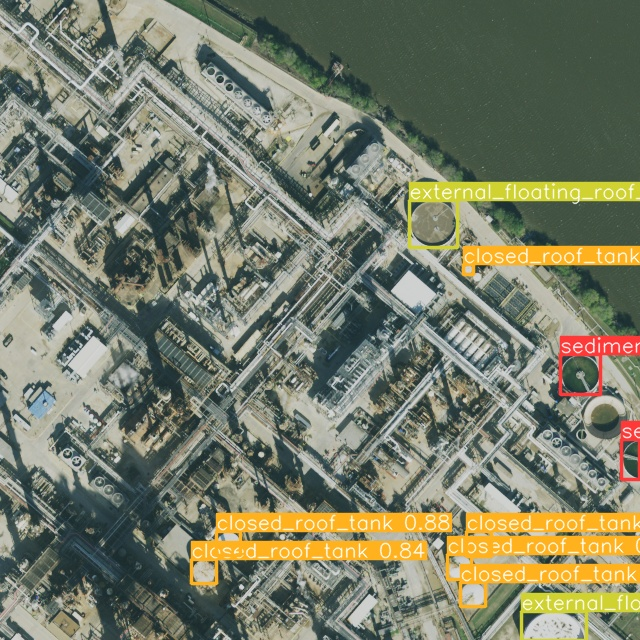

In [161]:
IPython.display.Image("/work/csr33/object_detection/runs/detect/predict21/image0.jpg")

In [91]:
split_tile[0]

<xarray.DataArray (band: 4, y: 640, x: 640)>
array([[[ 82, 116, ..., 104,  98],
        [ 70,  77, ..., 101, 106],
        ...,
        [132,  85, ...,  85,  78],
        [149, 122, ..., 114, 113]],

       [[ 83, 120, ..., 101,  94],
        [ 70,  78, ...,  99, 106],
        ...,
        [125,  79, ...,  89,  79],
        [138, 111, ..., 118, 120]],

       [[ 67, 106, ...,  85,  79],
        [ 54,  64, ...,  85,  92],
        ...,
        [104,  61, ...,  72,  62],
        [110,  83, ...,  98, 102]],

       [[161, 190, ..., 156, 155],
        [150, 158, ..., 156, 167],
        ...,
        [179, 148, ..., 171, 167],
        [184, 169, ..., 191, 194]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 3.387e+05 3.387e+05 ... 3.391e+05 3.391e+05
  * y            (y) float64 4.853e+06 4.853e+06 ... 4.853e+06 4.853e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_ARTIST:            Surdex Corporation, 636-368-4400, www.surdex.com
    TIFFTAG_DATETIME:          2021:11:29 20:52:29
    TIFFTAG_DOCUMENTNAME:      Kezar Falls SW 4307009
    TIFFTAG_HOSTCOMPUTER:      AMDNODE6
    TIFFTAG_IMAGEDESCRIPTION:  Image courtesy of USDA Farm Service Agency's N...
    scale_factor:              1.0
    add_offset:                0.0

In [101]:
.shape

(640, 640, 3)


0: 640x640 (no detections), 37.3ms
Speed: 26.7ms preprocess, 37.3ms inference, 227.8ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
def chip_tiles(self, item_dim): 
    """Segment tiles into item_dim x item_dim pixel chips, preserving resolution
    """
    item_dim = int(512)
    print("chip tiles")
    self.tile_names = os.listdir(self.tiles_dir)  # get a list of all of the tiles in tiles directory
    for tile_name in self.tile_names:  # index over the tiles in the tiles_dir
        print(tile_name)
        tile_name_wo_ext, ext = os.path.splitext(tile_name)  # File name
        tile = cv2.imread(os.path.join(self.tiles_dir, tile_name))
        tile_height, tile_width, tile_channels = tile.shape  # the size of the tile
        # divide the tile into item_dim by item_dim chips (rounding up)
        row_index = math.ceil(tile_height / item_dim)
        col_index = math.ceil(tile_width / item_dim)

        count = 0
        for y in range(0, row_index):
            for x in range(0, col_index):
                # 
                # specify the path to save the image
                chip_img = fc.tile_to_chip_array(tile, x, y, item_dim) #chip tile
                chip_name = tile_name_wo_ext + '_' + f"{y:02}" + '_' + f"{x:02}" + '.jpg'  #
                chips_save_path = os.path.join(self.chips_dir, chip_name)  # row_col.jpg                    
                cv2.imwrite(os.path.join(chips_save_path), chip_img) # save image
                count += 1
        print(count)


In [ ]:
def tile_to_chip_array(tile, x, y, item_dim): #used
    """
    ## https://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python
    x: col index
    y: row index
    """
    dimensions = tile.shape[2]
    chip_img = tile[y*item_dim:y*item_dim+item_dim, x*(item_dim):x*(item_dim)+item_dim]
    #add in back space if it is the edge of an image
    if (chip_img.shape[0] != item_dim) & (chip_img.shape[1] != item_dim): #width
        #print("Incorrect Width")
        chip = np.zeros((item_dim,item_dim,dimensions), np.uint8)
        chip[0:chip_img.shape[0], 0:chip_img.shape[1]] = chip_img
        chip_img = chip
    if chip_img.shape[0] != item_dim:  #Height
        black_height = item_dim  - chip_img.shape[0] #Height
        black_width = item_dim #- chip_img.shape[1] #width
        black_img = np.zeros((black_height,black_width,  dimensions), np.uint8)
        chip_img = np.concatenate([chip_img, black_img])
    if chip_img.shape[1] != item_dim: #width
        black_height = item_dim #- chip_img.shape[0] #Height
        black_width = item_dim - chip_img.shape[1] #width
        black_img = np.zeros((black_height,black_width, dimensions), np.uint8)
        chip_img = np.concatenate([chip_img, black_img],1)
    return(chip_img)

In [ ]:
numpynp.zeros((640,1280,3))	np.ndarray	HWC format with BGR channels uint8 (0-255).